In [423]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [444]:
# set_dir = 'set1_short'
# out_plot = 'pred1.pdf'
# threshold = 0.18

# set_dir = 'set2_short'
# out_plot = 'pred2.pdf'
# threshold = 0.12

set_dir = 'set3_short'
out_plot = 'pred3.pdf'
threshold = 0.32

data = pd.read_csv(set_dir + '/infection_risk.txt')
data

,day,cycle,prevalence,name,smell_and_taste_loss,cough,fatigue,skipped_meals,status,risk
0,2,10,0.001086,Individual1516,0.0,0.0,0.0,1.0,L,0.957379
1,3,12,0.001195,Individual6576,0.0,0.0,0.0,0.0,S,0.771716
2,3,13,0.001521,Individual4653,0.0,1.0,0.0,0.0,L,0.827140
3,3,13,0.001521,Individual1458,1.0,0.0,0.0,0.0,L,1.000000
4,3,13,0.001521,Individual9195,0.0,1.0,0.0,1.0,L,1.000000
...,...,...,...,...,...,...,...,...,...,...
7355,24,99,0.716663,Individual5914,0.0,0.0,0.0,1.0,L,0.301082
7356,24,99,0.716663,Individual8358,0.0,1.0,0.0,0.0,L,0.310633
7357,24,99,0.716663,Individual1019,0.0,0.0,0.0,0.0,L,0.260757
7358,24,99,0.716663,Individual2695,0.0,1.0,0.0,0.0,L,0.374928


In [445]:
susceptibles = data[data['status'] == 'S']
print(np.mean(susceptibles['risk']), np.std(susceptibles['risk']))

latents = data[data['status'] == 'L']
print(np.mean(latents['risk']), np.std(latents['risk']))

threshold2 = (np.mean(susceptibles['risk']) + np.mean(latents['risk']))/2                     
print(threshold2)
# threshold = threshold2

0.5536427469763189 0.3100898402018436
0.6329796864617723 0.3083163882217683
0.5933112167190455


In [446]:
cycle = list(data['cycle'])
name = list(data['name'])
status = list(data['status'])
risk = list(data['risk'])

all_cases = {}
for (n, c, s, r) in zip(name, cycle, status, risk):
    if n in all_cases:
        log = all_cases[n]
    else:
        log = []
        all_cases[n] = log
    log += [[c, s, min(1, r)]]   
        
noninf = []
infected = []
for n in all_cases:
    log = all_cases[n]
    if 4 < len(log):
        c = []
        r = []
        inf = False
        for v in log:
            c += [v[0]]
            r += [v[2]]
            if v[1] != 'S': inf = True
        if inf:
            infected += [[c, r]]
        else:
            noninf += [[c, r]]           

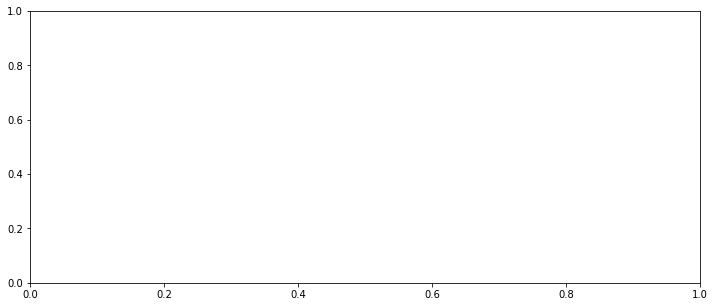

In [447]:
fig, _ = plt.subplots(figsize=(12,5))

ninfcolor = sns.xkcd_rgb["denim blue"]
infcolor = sns.xkcd_rgb["pale red"]

for hist in noninf:
    plt.plot(hist[0], hist[1], linewidth=2, color=ninfcolor, alpha=0.2)

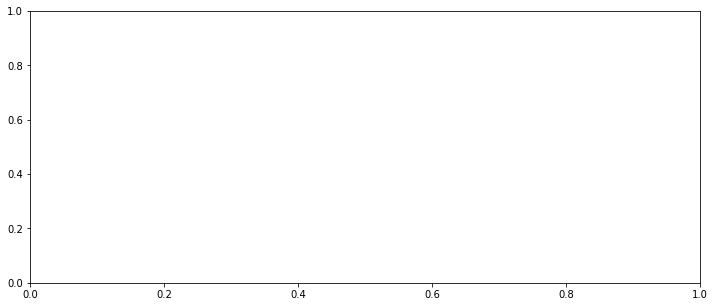

In [448]:
fig, _ = plt.subplots(figsize=(12,5))

for hist in infected:
    plt.plot(hist[0], hist[1], linewidth=2, color=infcolor, alpha=0.2)

In [449]:
def score_confidence_interval(score_fun, y_true, y_pred, pvalue, niter):
    """
    Calculation of the confidence interval for a given p-value using bootstrap sampling
    http://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals
    """
    
    n_bootstraps = niter
    bootstrapped_scores = []
    
#     rng_seed = 42  # control reproducibility
#     rng = np.random.RandomState(rng_seed)

    rng = np.random.RandomState()
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred) - 1, len(y_pred))
        
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = score_fun(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    confidence_lower = sorted_scores[int((1 - pvalue) * len(sorted_scores))] 
    confidence_upper = sorted_scores[int(pvalue * len(sorted_scores))]

    return [confidence_lower, confidence_upper]

def auc_confidence_interval(y_true, y_pred, pvalue=0.95, niter=1000):
    return score_confidence_interval(roc_auc_score, y_true, y_pred, pvalue, niter)

In [450]:
all_scores = np.array(data['risk'])
all_truths = np.array(data['status'] != 'S')
#print(np.mean(susceptibles['risk']), np.std(susceptibles['risk']))

print(len(all_scores))
print(len(all_truths))

7360
7360


In [451]:
class_threshold = threshold
p_value = 0.95
all_preds = np.array([int(class_threshold < p) for p in all_scores])

ytrue = np.array(all_truths)
probs = np.array(all_scores)
ypred = all_preds


auc = roc_auc_score(ytrue, probs)
fpr, tpr, thresholds = roc_curve(ytrue, probs) 
brier = brier_score_loss(ytrue, probs)
# cal, dis = caldis(ytrue, probs)
acc = accuracy_score(ytrue, ypred)
precision, recall, f1score, support = precision_recall_fscore_support(ytrue, ypred)

auc_ci = auc_confidence_interval(ytrue, probs, p_value)

P = N = 0
TP = TN = 0
FP = FN = 0
for i in range(len(ytrue)):
    if ytrue[i] == 1:
        P += 1
        if ypred[i] == 1: TP += 1
        else: FN += 1
    else:
        N += 1
        if ypred[i] == 0: TN += 1
        else: FP += 1
            
sens = float(TP)/P
spec = float(TN)/N

# Likelihood ratios
# https://en.wikipedia.org/wiki/Likelihood_ratios_in_diagnostic_testing
lr_pos = sens / (1 - spec) if spec < 1 else np.inf
lr_neg = (1 - sens) / spec if 0 < spec else np.inf

In [452]:
# print "True outcomes:", ytrue
# print "Prediction   :", ypred
pinf = 100 * (float(np.sum(ytrue)) / len(ytrue))
print("Number of predictions  :", len(ytrue))
print("Number of infected     :", np.sum(ytrue)) 
print("Percentage of infected : %0.2f" % pinf)

print("")
print("Measures of performance") 
print("AUC           : %0.2f (%0.2f, %0.2f)" % (auc, auc_ci[0], auc_ci[1])) 
print("Brier         : %0.2f" % brier) 
# print("Calibration   :", cal) 
# print("Discrimination:", dis) 
print("Accuracy      : %0.2f" % acc) 
print("Sensitivity   : %0.2f" % sens) 
print("Specificity   : %0.2f" % spec) 
# print("PPV           : %0.2f" % ppv) 
# print("NPV           : %0.2f" % npv) 

Number of predictions  : 7360
Number of infected     : 6656
Percentage of infected : 90.43

Measures of performance
AUC           : 0.57 (0.56, 0.59)
Brier         : 0.25
Accuracy      : 0.76
Sensitivity   : 0.81
Specificity   : 0.28


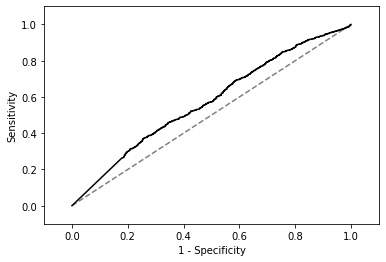

In [453]:
fig, ax = plt.subplots()
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.plot([0, 1], [0, 1], 'k--', c='grey')
plt.plot(fpr, tpr, color='black')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
fig.savefig(out_plot)